# Impact Score

### Baseline

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import torch
import torch.nn as nn
from sentence_transformers import SentenceTransformer
from collections import defaultdict
from sklearn.metrics import r2_score

In [13]:
import pandas as pd

In [14]:
# 1. 데이터 준비 및 타겟 생성
df1 = pd.read_csv("../../db/news_2023_2025_external.csv")
df2 = pd.read_csv("../../db/news_2023_2025_metadata.csv")

df = df1.merge(df2, on="news_id")
df.replace([np.inf, -np.inf], np.nan, inplace=True)

df = df.dropna()

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13425 entries, 238 to 13748
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   news_id                     13425 non-null  object 
 1   d_minus_5_date_close        13425 non-null  float64
 2   d_minus_5_date_volume       13425 non-null  float64
 3   d_minus_5_date_foreign      13425 non-null  float64
 4   d_minus_5_date_institution  13425 non-null  float64
 5   d_minus_5_date_individual   13425 non-null  float64
 6   d_minus_4_date_close        13425 non-null  float64
 7   d_minus_4_date_volume       13425 non-null  float64
 8   d_minus_4_date_foreign      13425 non-null  float64
 9   d_minus_4_date_institution  13425 non-null  float64
 10  d_minus_4_date_individual   13425 non-null  float64
 11  d_minus_3_date_close        13425 non-null  float64
 12  d_minus_3_date_volume       13425 non-null  float64
 13  d_minus_3_date_foreign      13425 

In [32]:
df.d_plus_2_date_close.std()

0.07207201918697281

<Axes: xlabel='d_plus_5_date_close', ylabel='Count'>

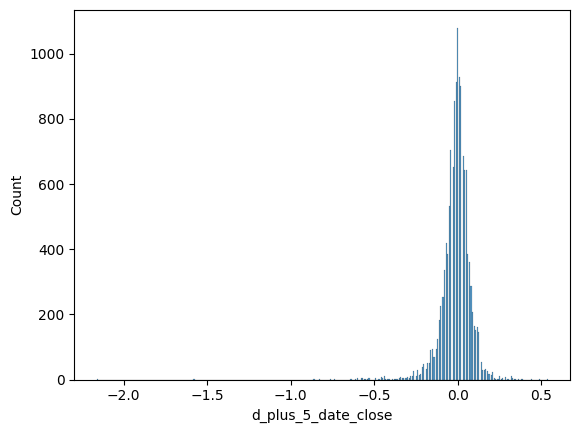

In [ ]:
import seaborn as sns

sns.histplot(df.d_plus_5_date_close.)

In [6]:
df.iloc[5000]

news_id                                                           20241101_0137
d_minus_5_date_close                                                       0.06
d_minus_5_date_volume                                                      0.28
d_minus_5_date_foreign                                                    -1.77
d_minus_5_date_institution                                                 1.34
d_minus_5_date_individual                                                 44.02
d_minus_4_date_close                                                       0.02
d_minus_4_date_volume                                                      0.22
d_minus_4_date_foreign                                                     1.08
d_minus_4_date_institution                                                -0.29
d_minus_4_date_individual                                                -19.04
d_minus_3_date_close                                                      -0.01
d_minus_3_date_volume                   

In [25]:
# 2. 타겟 생성
target_cols = ['d_plus_1_date_close', 'd_plus_2_date_close', 'd_plus_3_date_close', 'd_plus_4_date_close', 'd_plus_5_date_close']
df['target'] = df[target_cols].values.tolist()

In [26]:
train_targets = df[target_cols].values.tolist()

In [27]:
import numpy as np

train_targets = df[target_cols].values.tolist()  # → list of lists
train_targets = np.array(train_targets)  # → (N, 5) numpy array

baseline_mean = train_targets.mean(axis=0)  # shape: (5,)
baseline_std = train_targets.std(axis=0)  # shape: (5,)

In [11]:
baseline_mean

array([-0.0078573 , -0.0083497 , -0.00810895, -0.00799404, -0.00891119])

In [12]:
baseline_std

array([0.06588189, 0.07283064, 0.07710478, 0.08238087, 0.08863377])

특성공학컬럼 생성

In [ ]:
def feature_engineer_stock_data(df: pd.DataFrame) -> pd.DataFrame:
    numeric_cols_to_convert = [col for col in df.columns if 'd_minus' in col and ('close' in col or 'volume' in col or 'foreign' in col or 'institution' in col or 'individual' in col) and df[col].dtype == 'int64']
    for col in numeric_cols_to_convert:
        df.loc[:, col] = df[col].astype(float)

    if 'news_id' in df.columns:
        try:
            df.loc[:, 'date'] = pd.to_datetime(df['news_id'].str[:8], format='%Y%m%d', errors='coerce')
        except Exception:
            df.loc[:, 'date'] = pd.NaT
    else:
        df.loc[:, 'date'] = pd.NaT

    if 'stock_list' in df.columns:
        df.loc[:, 'stock_code'] = df['stock_list'].apply(
            lambda x: x[0] if isinstance(x, list) and len(x) > 0 else np.nan
        )
        df.loc[:, 'stock_code'] = df['stock_code'].fillna('Unknown_Stock_For_Imputation')
    else:
        df.loc[:, 'stock_code'] = 'Unknown_Stock_For_Imputation'

    # 일별 수익률 특성
    daily_return_cols = []
    for i in range(1, 5):
        current_day_close = f'd_minus_{i}_date_close'
        prev_day_close = f'd_minus_{i+1}_date_close'
        new_col_name = f'd_minus_{i}_daily_return'

        if current_day_close in df.columns and prev_day_close in df.columns:
            df.loc[:, new_col_name] = (df[current_day_close] - df[prev_day_close]) / df[prev_day_close].replace(0, np.nan)
            daily_return_cols.append(new_col_name)

    # 이동 평균 특성
    moving_average_cols = []
    if all(col in df.columns for col in ['d_minus_1_date_close', 'd_minus_2_date_close', 'd_minus_3_date_close']):
        df.loc[:, 'ma_3_d_minus_1'] = df[['d_minus_1_date_close', 'd_minus_2_date_close', 'd_minus_3_date_close']].mean(axis=1)
        moving_average_cols.append('ma_3_d_minus_1')

    if all(col in df.columns for col in ['d_minus_1_date_close', 'd_minus_2_date_close', 'd_minus_3_date_close', 'd_minus_4_date_close', 'd_minus_5_date_close']):
        df.loc[:, 'ma_5_d_minus_1'] = df[['d_minus_1_date_close', 'd_minus_2_date_close', 'd_minus_3_date_close', 'd_minus_4_date_close', 'd_minus_5_date_close']].mean(axis=1)
        moving_average_cols.append('ma_5_d_minus_1')

    # 변동성 특성
    volatility_cols = []
    if daily_return_cols and len(daily_return_cols) >= 2:
        df.loc[:, 'vol_5_d_minus_1'] = df[daily_return_cols].std(axis=1)
        volatility_cols.append('vol_5_d_minus_1')

    # 결측치 처리 
    features_to_process_and_impute = daily_return_cols + moving_average_cols + volatility_cols

    if not features_to_process_and_impute:
        return df

    # 퀀타일 계산 임시 데이터프레임
    temp_df_for_quantile = df[features_to_process_and_impute].dropna()

    for col in daily_return_cols:
        if col in temp_df_for_quantile.columns and not temp_df_for_quantile[col].empty:
            lower_bound = temp_df_for_quantile[col].quantile(0.01)
            upper_bound = temp_df_for_quantile[col].quantile(0.99)
            df.loc[:, col] = np.clip(df[col], lower_bound, upper_bound)

    if 'vol_5_d_minus_1' in df.columns and 'vol_5_d_minus_1' in temp_df_for_quantile.columns and not temp_df_for_quantile['vol_5_d_minus_1'].empty:
        upper_bound_vol = temp_df_for_quantile['vol_5_d_minus_1'].quantile(0.99)
        df.loc[:, 'vol_5_d_minus_1'] = np.clip(df['vol_5_d_minus_1'], 0, upper_bound_vol)

    # NaN 값 처리
    if 'stock_code' in df.columns and 'date' in df.columns and not df['date'].isnull().all():
        df_sorted = df.sort_values(by=['stock_code', 'date']).copy()

        for col in features_to_process_and_impute:
            if col in df_sorted.columns:
                df_sorted.loc[:, col] = df_sorted.groupby('stock_code')[col].transform(
                    lambda x: x.interpolate(method='linear', limit_direction='both', limit_area='inside')
                )
                df_sorted.loc[:, col] = df_sorted.groupby('stock_code')[col].transform(
                    lambda x: x.fillna(method='ffill').fillna(method='bfill')
                )
                if df_sorted[col].isna().any():
                    df_sorted.loc[:, col] = df_sorted[col].fillna(0)

        df = df_sorted.loc[df.index].copy()
    else:
        for col in features_to_process_and_impute:
            if col in df.columns and df[col].isna().any():
                fill_value = df[col].mean()
                if not pd.isna(fill_value):
                    df.loc[:, col] = df[col].fillna(fill_value)
                else:
                    df.loc[:, col] = df[col].fillna(0)
    return df

df = feature_engineer_stock_data(df.copy())

C:\Users\user\AppData\Local\Temp\ipykernel_10688\3736084660.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Unknown_Stock_For_Imputation' 'Unknown_Stock_For_Imputation'
 'Unknown_Stock_For_Imputation' ... 'Unknown_Stock_For_Imputation'
 'Unknown_Stock_For_Imputation' 'Unknown_Stock_For_Imputation']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, 'stock_code'] = df['stock_code'].fillna('Unknown_Stock_For_Imputation')
C:\Users\user\AppData\Local\Temp\ipykernel_10688\3736084660.py:81: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda x: x.fillna(method='ffill').fillna(method='bfill')
C:\Users\user\AppData\Local\Temp\ipykernel_10688\3736084660.py:81: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfil

피쳐 스케일링

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13425 entries, 238 to 13748
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   news_id                     13425 non-null  object        
 1   d_minus_5_date_close        13425 non-null  float64       
 2   d_minus_5_date_volume       13425 non-null  float64       
 3   d_minus_5_date_foreign      13425 non-null  float64       
 4   d_minus_5_date_institution  13425 non-null  float64       
 5   d_minus_5_date_individual   13425 non-null  float64       
 6   d_minus_4_date_close        13425 non-null  float64       
 7   d_minus_4_date_volume       13425 non-null  float64       
 8   d_minus_4_date_foreign      13425 non-null  float64       
 9   d_minus_4_date_institution  13425 non-null  float64       
 10  d_minus_4_date_individual   13425 non-null  float64       
 11  d_minus_3_date_close        13425 non-null  float64      

In [ ]:
# standard
group_price_close = [
    'd_minus_5_date_close', 'd_minus_4_date_close',
    'd_minus_3_date_close', 'd_minus_2_date_close',
    'd_minus_1_date_close'
]

# RobustScaler
group_volume = [
    'd_minus_5_date_volume', 'd_minus_4_date_volume',
    'd_minus_3_date_volume', 'd_minus_2_date_volume',
    'd_minus_1_date_volume'
]

# MinMaxScaler
group_foreign = [
    'd_minus_5_date_foreign', 'd_minus_4_date_foreign',
    'd_minus_3_date_foreign', 'd_minus_2_date_foreign',
    'd_minus_1_date_foreign'
]

# MinMaxScaler
group_institution = [
    'd_minus_5_date_institution', 'd_minus_4_date_institution',
    'd_minus_3_date_institution', 'd_minus_2_date_institution',
    'd_minus_1_date_institution'
]

# MinMaxScaler
group_individual = [
    'd_minus_5_date_individual', 'd_minus_4_date_individual',
    'd_minus_3_date_individual', 'd_minus_2_date_individual',
    'd_minus_1_date_individual'
]

# StandardScaler
group_macro = ['fx', 'bond10y', 'base_rate']

# RobustScaler
daily_return_cols = ['d_minus_1_daily_return', 'd_minus_2_daily_return', 'd_minus_3_daily_return', 'd_minus_4_daily_return']

# StandardScaler
moving_average_cols = ['ma_3_d_minus_1', 'ma_5_d_minus_1']

# RobustScaler
volatility_cols = ['vol_5_d_minus_1']


groups = [
    group_macro,
    group_volume,
    group_foreign,
    group_institution,
    group_individual,
    group_price_close,     
    daily_return_cols,     
    moving_average_cols,  
    volatility_cols     
]

scaler_choices = [
    StandardScaler(), # group_macro
    RobustScaler(),   # group_volume
    MinMaxScaler(),   # group_foreign
    MinMaxScaler(),   # group_institution
    MinMaxScaler(),   # group_individual
    StandardScaler(), # group_price_close 
    RobustScaler(),   # daily_return_cols
    StandardScaler(), # moving_average_cols 
    RobustScaler()    # volatility_cols
]

external_cols = []
for group in groups:
    valid_group_cols = [col for col in group if col in df.columns]
    external_cols.extend(valid_group_cols)


# 3. 훈련/검증 분할 및 스케일링 
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

fitted_scalers = {}

for i, group in enumerate(groups):
    scaler = scaler_choices[i]
    group_in_train = [col for col in group if col in train_df.columns]
    group_in_val = [col for col in group if col in val_df.columns]

    if not group_in_train:
        continue

    scaler.fit(train_df[group_in_train])
    fitted_scalers[i] = scaler

    train_df.loc[:, group_in_train] = scaler.transform(train_df[group_in_train])
    if group_in_val: # 검증 데이터에도 해당 컬럼이 있을 경우에만
        val_df.loc[:, group_in_val] = scaler.transform(val_df[group_in_val])
    else:
        pass


# 타겟 변수 스케일링 
target_scaler = StandardScaler()
train_targets_np = np.array(train_df['target'].tolist())
val_targets_np = np.array(val_df['target'].tolist())

target_scaler.fit(train_targets_np)

train_df['target_scaled'] = target_scaler.transform(train_targets_np).tolist()
val_df['target_scaled'] = target_scaler.transform(val_targets_np).tolist()



최종 external_cols 수: 35
최종 external_cols 예시: ['fx', 'bond10y', 'base_rate', 'd_minus_5_date_volume', 'd_minus_4_date_volume', 'd_minus_3_date_volume', 'd_minus_2_date_volume', 'd_minus_1_date_volume', 'd_minus_5_date_foreign', 'd_minus_4_date_foreign', 'd_minus_3_date_foreign', 'd_minus_2_date_foreign', 'd_minus_1_date_foreign', 'd_minus_5_date_institution', 'd_minus_4_date_institution', 'd_minus_3_date_institution', 'd_minus_2_date_institution', 'd_minus_1_date_institution', 'd_minus_5_date_individual', 'd_minus_4_date_individual', 'd_minus_3_date_individual', 'd_minus_2_date_individual', 'd_minus_1_date_individual', 'd_minus_5_date_close', 'd_minus_4_date_close', 'd_minus_3_date_close', 'd_minus_2_date_close', 'd_minus_1_date_close', 'd_minus_1_daily_return', 'd_minus_2_daily_return', 'd_minus_3_daily_return', 'd_minus_4_daily_return', 'ma_3_d_minus_1', 'ma_5_d_minus_1', 'vol_5_d_minus_1'] ...

--- 훈련/검증 데이터 스케일링 시작 ---


문장 임베딩 생성

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 임베딩 모델 초기화
model_emb = SentenceTransformer(
    "snunlp/KR-SBERT-V40K-klueNLI-augSTS",
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

print(f"\n훈련 데이터 임베딩 생성 ({len(train_df)}개 뉴스)")
train_summary_embedding = model_emb.encode(
    train_df["summary"].tolist(),
    batch_size=32,
    show_progress_bar=True,
    convert_to_tensor=True
)
train_df["embedding"] = train_summary_embedding.cpu().numpy().tolist()

print(f"\n검증 데이터 임베딩 생성 ({len(val_df)}개 뉴스)")
val_summary_embedding = model_emb.encode(
    val_df["summary"].tolist(),
    batch_size=32,
    show_progress_bar=True,
    convert_to_tensor=True
)
val_df["embedding"] = val_summary_embedding.cpu().numpy().tolist()

c:\Users\user\anaconda3\envs\tensor\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--snunlp--KR-SBERT-V40K-klueNLI-augSTS. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)



▶ 훈련 데이터 임베딩 생성 (10740개 뉴스)


Batches: 100%|██████████| 336/336 [00:26<00:00, 12.81it/s]



▶ 검증 데이터 임베딩 생성 (2685개 뉴스)


Batches: 100%|██████████| 84/84 [00:06<00:00, 13.43it/s]


데이터셋

In [ ]:
# Dataset 및 DataLoader
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, df, external_cols):
        self.embeddings = torch.tensor(df["embedding"].tolist(), dtype=torch.float32)
        self.external_features = torch.tensor(df[external_cols].values, dtype=torch.float32)
        self.targets = torch.tensor(df["target_scaled"].tolist(), dtype=torch.float32)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.external_features[idx], self.targets[idx]

train_dataset = CustomDataset(train_df, external_cols)
val_dataset = CustomDataset(val_df, external_cols)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

오토인코더

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, latent_dim * 2),
            nn.GELU(),
            nn.Linear(latent_dim * 2, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, latent_dim * 2),
            nn.GELU(),
            nn.Linear(latent_dim * 2, input_dim)
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

# 임베딩 차원
embedding_dim = model_emb.get_sentence_embedding_dimension()
latent_dim = 128 

ae_model = Autoencoder(input_dim=embedding_dim, latent_dim=latent_dim).to(device)

def freeze_module(module):
    for param in module.parameters():
        param.requires_grad = False

def train_autoencoder(model, train_loader, val_loader=None, epochs=10, device='cuda'):
    ae_optimizer = torch.optim.AdamW(
        list(model.encoder.parameters()) + list(model.decoder.parameters()),
        lr=1e-4,
        weight_decay=1e-5
    )
    criterion = nn.MSELoss()

    model.encoder.train()
    model.decoder.train()

    print("\n오토인코더 사전학습 시작")
    for epoch in range(epochs):
        total_loss = 0
        for batch_embedding, _, _ in train_loader: 
            embeddings = batch_embedding.to(device)

            latent = model.encoder(embeddings)
            reconstructed = model.decoder(latent)

            loss = criterion(reconstructed, embeddings)
            ae_optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            ae_optimizer.step()

            total_loss += loss.item()

        val_loss = 0
        if val_loader:
            model.eval()
            with torch.no_grad():
                for val_batch_embedding, _, _ in val_loader: 
                    val_embeddings = val_batch_embedding.to(device)
                    val_latent = model.encoder(val_embeddings)
                    val_reconstructed = model.decoder(val_latent)
                    val_loss += criterion(val_reconstructed, val_embeddings).item()
            model.train() # 학습 모드로 전환
            print(f"[AE] Epoch {epoch+1} | Train Loss: {total_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")
        else:
            print(f"[AE] Epoch {epoch+1} | Train Loss: {total_loss/len(train_loader):.4f}")

    model.encoder.eval()
    model.decoder.eval()
    return model

# 오토인코더 학습 
ae_model = train_autoencoder(ae_model, train_loader, val_loader, epochs=10, device=device)


▶ 오토인코더 사전학습 시작
[AE] Epoch 1 | Train Loss: 0.1634 | Val Loss: 0.1152
[AE] Epoch 2 | Train Loss: 0.0975 | Val Loss: 0.0833
[AE] Epoch 3 | Train Loss: 0.0759 | Val Loss: 0.0692
[AE] Epoch 4 | Train Loss: 0.0648 | Val Loss: 0.0607
[AE] Epoch 5 | Train Loss: 0.0577 | Val Loss: 0.0550
[AE] Epoch 6 | Train Loss: 0.0526 | Val Loss: 0.0506
[AE] Epoch 7 | Train Loss: 0.0486 | Val Loss: 0.0472
[AE] Epoch 8 | Train Loss: 0.0455 | Val Loss: 0.0444
[AE] Epoch 9 | Train Loss: 0.0429 | Val Loss: 0.0420
[AE] Epoch 10 | Train Loss: 0.0407 | Val Loss: 0.0401


예측 모델 재구성

In [ ]:
class ImportancePredictor(nn.Module):
    def __init__(self, ae_encoder, external_feature_dim, fcl_hidden=1024, dropout=0.25): 
        super().__init__()
        self.encoder = ae_encoder
        encoder_output_dim = ae_encoder[-1].out_features if isinstance(ae_encoder[-1], nn.Linear) else latent_dim

        self.predictor = nn.Sequential(
            nn.Linear(encoder_output_dim + external_feature_dim, fcl_hidden),
            nn.GELU(),
            nn.BatchNorm1d(fcl_hidden),
            nn.Dropout(dropout),

            nn.Linear(fcl_hidden, fcl_hidden // 2),
            nn.GELU(),
            nn.BatchNorm1d(fcl_hidden // 2),
            nn.Dropout(dropout),

            nn.Linear(fcl_hidden // 2, fcl_hidden // 4),
            nn.GELU(),
            nn.BatchNorm1d(fcl_hidden // 4),
            nn.Dropout(dropout),

            nn.Linear(fcl_hidden // 4, fcl_hidden // 8), 
            nn.GELU(),
            nn.BatchNorm1d(fcl_hidden // 8),
            nn.Dropout(dropout),

            nn.Linear(fcl_hidden // 8, 5)
        )

    def forward(self, embedding, external):
        latent = self.encoder(embedding)
        combined = torch.cat([latent, external], dim=1)
        return self.predictor(combined)

# ImportancePredictor 초기화
predictor = ImportancePredictor(
    ae_encoder=ae_model.encoder,
    external_feature_dim=len(external_cols) 
).to(device)

학습 및 검증 (프리징)

In [ ]:
def train_predictor(
    model,
    train_loader,
    val_loader,
    target_scaler,
    device='cuda',
    epochs=150, 
    patience=15, 
    max_grad_norm=1.0
):
    # 프리징 초기화
    freeze_module(model.encoder)  
    model.encoder.eval()  

    optimizer = torch.optim.AdamW(
        model.predictor.parameters(), 
        lr=5e-6,
        weight_decay=1e-6
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        'min',
        patience=5, 
        factor=0.5
    )
    criterion = nn.HuberLoss() 

    best_val_loss = float('inf')
    patience_counter = 0

    history = defaultdict(list)

    scaler = torch.cuda.amp.GradScaler()

    print("메인 예측기 학습 시작")
    for epoch in range(epochs):

        # --------- 훈련 단계 ---------
        model.train()

        train_loss = 0
        for batch_embedding, batch_external, batch_targets in train_loader:
            embeddings = batch_embedding.to(device)
            external_features = batch_external.to(device)
            targets = batch_targets.to(device)

            optimizer.zero_grad()

            with torch.autocast(device_type=device, dtype=torch.float16):
                preds = model(embeddings, external_features)
                loss = criterion(preds, targets)

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(
                model.predictor.parameters(),  
                max_grad_norm
            )
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # --------- 검증 단계 ---------
        model.eval()
        total_val_loss = 0
        all_preds, all_targets = [], []
        with torch.no_grad():
            for batch_embedding, batch_external, batch_targets in val_loader:
                embeddings = batch_embedding.to(device)
                external_features = batch_external.to(device)
                targets = batch_targets.to(device)

                with torch.autocast(device_type=device, dtype=torch.float16):
                    preds = model(embeddings, external_features)
                    loss = criterion(preds, targets)
                    total_val_loss += loss.item()
                    all_preds.append(preds.cpu())
                    all_targets.append(targets.cpu())

        avg_val_loss = total_val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        all_preds_np = torch.cat(all_preds).numpy()
        all_targets_np = torch.cat(all_targets).numpy()
        preds_inv = target_scaler.inverse_transform(all_preds_np)
        targets_inv = target_scaler.inverse_transform(all_targets_np)

        mae = nn.L1Loss()(torch.tensor(preds_inv), torch.tensor(targets_inv)).item()
        rmse = torch.sqrt(nn.MSELoss()(torch.tensor(preds_inv), torch.tensor(targets_inv))).item()
        r2 = r2_score(targets_inv, preds_inv)

        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.4f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.2e}")

        direction_match = (np.sign(preds_inv) == np.sign(targets_inv))
        directional_accuracy = np.mean(direction_match)
        print(f"Directional Accuracy: {directional_accuracy:.4f}")


        scheduler.step(avg_val_loss)

        # --------- 조기 종료 ---------
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_epoch = epoch + 1
            best_mae = mae
            best_r2 = r2
        else:
            patience_counter += 1
            print(f" -> 조기 종료 카운터: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print(f" -> epoch {epoch+1}에서 조기 종료!")
                break

    print(f"최적 모델: Epoch {best_epoch} | MAE: {best_mae:.2f} | R²: {best_r2:.4f}")
    return model

# 최종 예측기 학습 실행
trained_predictor = train_predictor(
    predictor,
    train_loader,
    val_loader,
    target_scaler,
    device=device,
    epochs=150, 
    patience=15 
)

C:\Users\user\AppData\Local\Temp\ipykernel_10688\2944849852.py:34: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



▶ 메인 예측기 학습 시작
[Epoch 1] Train Loss: 0.4712 | Val Loss: 0.3768 | MAE: 0.05 | RMSE: 0.09 | R²: -0.0887 | LR: 5.00e-06
Directional Accuracy: 0.4898
[Epoch 2] Train Loss: 0.4608 | Val Loss: 0.3690 | MAE: 0.05 | RMSE: 0.08 | R²: -0.0712 | LR: 5.00e-06
Directional Accuracy: 0.4924
[Epoch 3] Train Loss: 0.4498 | Val Loss: 0.3637 | MAE: 0.05 | RMSE: 0.08 | R²: -0.0570 | LR: 5.00e-06
Directional Accuracy: 0.4956
[Epoch 4] Train Loss: 0.4416 | Val Loss: 0.3597 | MAE: 0.05 | RMSE: 0.08 | R²: -0.0480 | LR: 5.00e-06
Directional Accuracy: 0.5038
[Epoch 5] Train Loss: 0.4349 | Val Loss: 0.3578 | MAE: 0.05 | RMSE: 0.08 | R²: -0.0429 | LR: 5.00e-06
Directional Accuracy: 0.5004
[Epoch 6] Train Loss: 0.4297 | Val Loss: 0.3535 | MAE: 0.05 | RMSE: 0.08 | R²: -0.0319 | LR: 5.00e-06
Directional Accuracy: 0.5032
[Epoch 7] Train Loss: 0.4253 | Val Loss: 0.3528 | MAE: 0.05 | RMSE: 0.08 | R²: -0.0327 | LR: 5.00e-06
Directional Accuracy: 0.5061
[Epoch 8] Train Loss: 0.4238 | Val Loss: 0.3530 | MAE: 0.05 | RMSE:

모델 저장

In [ ]:
import joblib
import torch.onnx

# 입력 특성별 스케일러 
for idx, scaler in fitted_scalers.items():
    joblib.dump(scaler, f"scaler_group_{idx}.joblib")

# 타겟 스케일러 
joblib.dump(target_scaler, "target_scaler.joblib")

dummy_embedding = torch.randn(1, embedding_dim, device=device)

# encoder만 ONNX로 저장
torch.onnx.export(
    ae_model.encoder,
    dummy_embedding,
    "ae_encoder.onnx",
    input_names=["embedding"],
    output_names=["latent"],
    dynamic_axes={"embedding": {0: "batch_size"}, "latent": {0: "batch_size"}},
    opset_version=17
)

# 외부 피처 차원 정보
external_feature_dim = len(external_cols)
dummy_external = torch.randn(1, external_feature_dim, device=device)

# predictor 전체 ONNX로 저장
torch.onnx.export(
    predictor,
    (dummy_embedding, dummy_external),
    "predictor.onnx",
    input_names=["embedding", "external"],
    output_names=["output"],
    dynamic_axes={
        "embedding": {0: "batch_size"},
        "external": {0: "batch_size"},
        "output": {0: "batch_size"}
    },
    opset_version=17
)


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13425 entries, 238 to 13748
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   news_id                     13425 non-null  object        
 1   d_minus_5_date_close        13425 non-null  float64       
 2   d_minus_5_date_volume       13425 non-null  float64       
 3   d_minus_5_date_foreign      13425 non-null  float64       
 4   d_minus_5_date_institution  13425 non-null  float64       
 5   d_minus_5_date_individual   13425 non-null  float64       
 6   d_minus_4_date_close        13425 non-null  float64       
 7   d_minus_4_date_volume       13425 non-null  float64       
 8   d_minus_4_date_foreign      13425 non-null  float64       
 9   d_minus_4_date_institution  13425 non-null  float64       
 10  d_minus_4_date_individual   13425 non-null  float64       
 11  d_minus_3_date_close        13425 non-null  float64      

In [20]:
df.target

238           [0.01, 0.03, 0.03, 0.03, 0.05]
239      [-0.05, -0.03, -0.09, -0.02, -0.05]
240         [0.02, 0.03, 0.02, -0.01, -0.01]
241        [-0.0, 0.03, -0.01, -0.04, -0.04]
242           [0.01, 0.04, 0.03, 0.01, 0.02]
                        ...                 
13744         [0.02, 0.03, 0.05, 0.05, 0.05]
13745    [-0.01, -0.03, -0.04, -0.05, -0.06]
13746     [-0.4, -0.33, -0.33, -0.38, -0.49]
13747         [0.02, 0.03, 0.05, 0.05, 0.05]
13748         [0.03, 0.03, 0.04, 0.03, 0.06]
Name: target, Length: 13425, dtype: object